# Mini-projeto K-Means

* Camila Vieira
* José Vinicius

##Importações

In [1]:
!pip install kneed
!pip install scikit-learn-extra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from kneed import KneeLocator
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances

##Preparação dos Dados

In [101]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SI/College.csv")
df.head()

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [102]:
df['Private'] = df['Private'].replace({'No': 0, 'Yes': 1})
binary_att = df[['Private']]
df = df.iloc[:, 2:]
df.info() #sem valores do tipo float ou categóricos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Apps         777 non-null    int64  
 1   Accept       777 non-null    int64  
 2   Enroll       777 non-null    int64  
 3   Top10perc    777 non-null    int64  
 4   Top25perc    777 non-null    int64  
 5   F.Undergrad  777 non-null    int64  
 6   P.Undergrad  777 non-null    int64  
 7   Outstate     777 non-null    int64  
 8   Room.Board   777 non-null    int64  
 9   Books        777 non-null    int64  
 10  Personal     777 non-null    int64  
 11  PhD          777 non-null    int64  
 12  Terminal     777 non-null    int64  
 13  S.F.Ratio    777 non-null    float64
 14  perc.alumni  777 non-null    int64  
 15  Expend       777 non-null    int64  
 16  Grad.Rate    777 non-null    int64  
dtypes: float64(1), int64(16)
memory usage: 103.3 KB


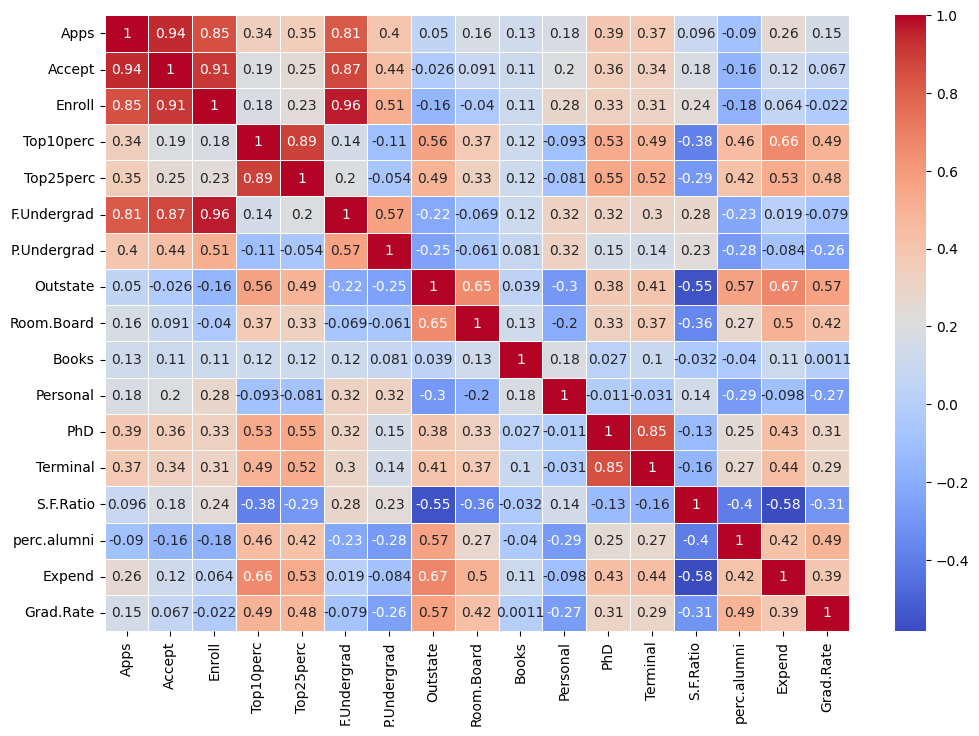

In [103]:
correlacao = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

In [104]:
#Remover as colunas com alta correlação para diminuir a dimensionalidade do modelo
colunas_para_remover = set()
for i in range(len(correlacao.columns)):
  for j in range(i):
    if abs(correlacao.iloc[i, j]) > 0.8:
      coluna = correlacao.columns[i]
      colunas_para_remover.add(coluna)
    if abs(correlacao.iloc[i, j]) < -0.8:
      coluna = correlacao.columns[i]
      colunas_para_remover.add(coluna)
print(colunas_para_remover)
df_sem_correlacao_alta = df.drop(columns=colunas_para_remover)

{'Terminal', 'F.Undergrad', 'Accept', 'Top25perc', 'Enroll'}


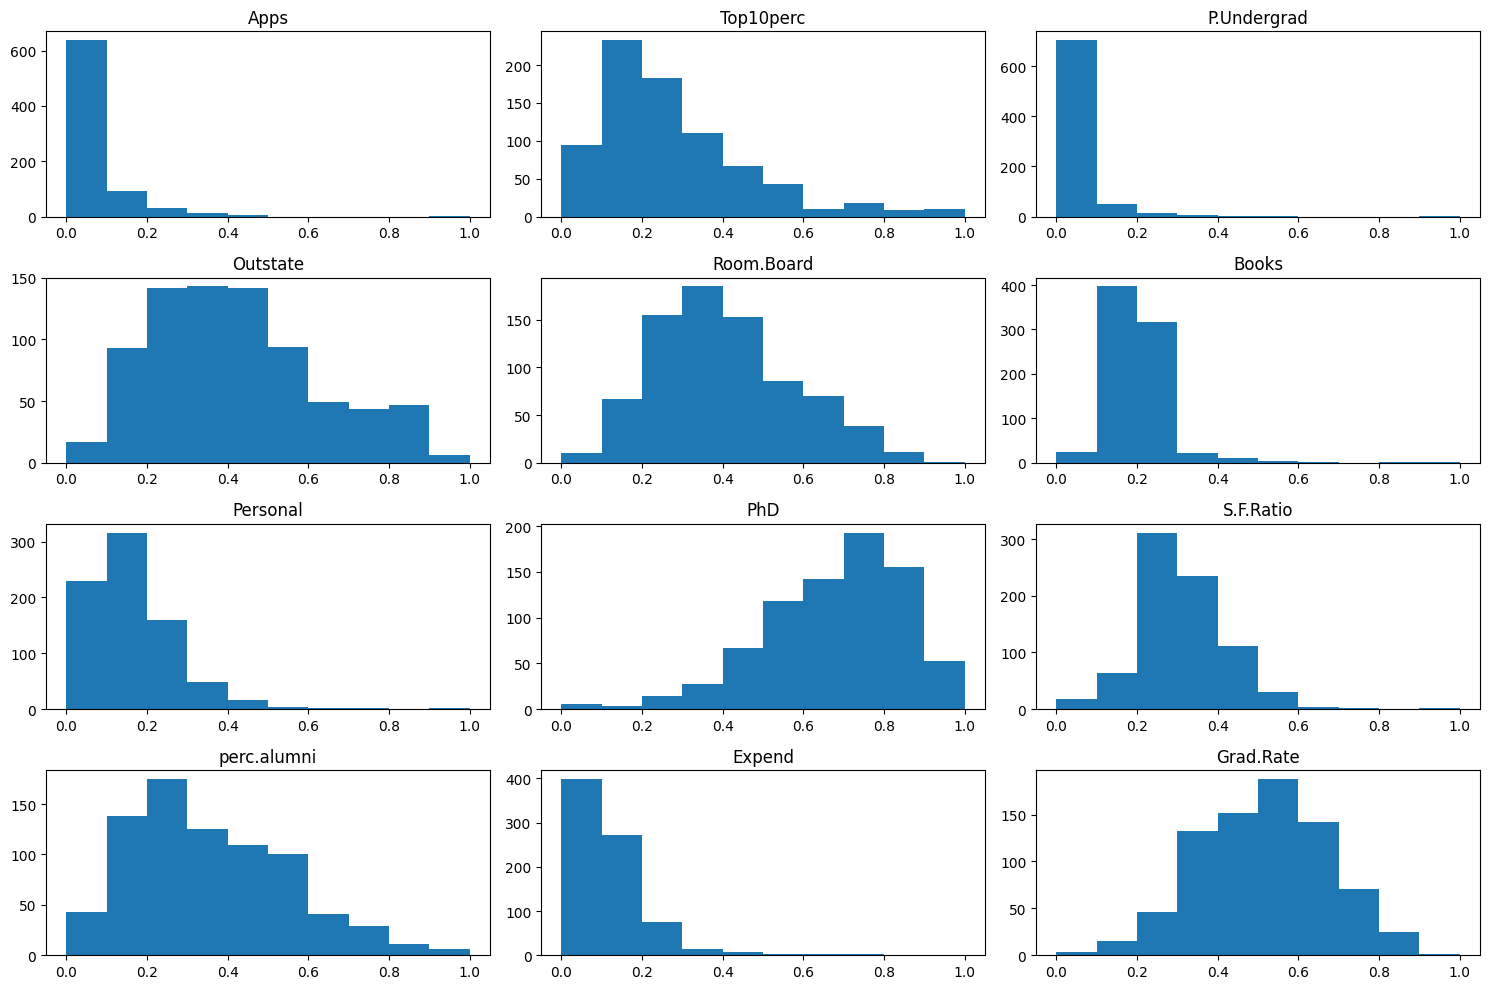

In [105]:
#Normalização do modelo
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_sem_correlacao_alta), columns=df_sem_correlacao_alta.columns)

plt.figure(figsize=(15, 10))
for i, coluna in enumerate(df_normalized.columns, 1):
    plt.subplot(4, 3, i)
    plt.hist(df_normalized[coluna])
    plt.title(coluna)
plt.tight_layout()
plt.show()

In [106]:
data = df_normalized

##Valor de k

In [107]:
def bic_score(kmeans, X):
  centers = [kmeans.cluster_centers_]
  labels = kmeans.labels_
  m = kmeans.n_clusters
  n = np.bincount(labels)
  N, d = X.shape

  cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X.iloc[labels == i], [centers[0][i]], 'euclidean')**2) for i in range(m)])
  const_term = 0.5 * m * np.log(N) * (d+1)
  BIC = np.sum([n[i] * np.log(n[i]) - n[i] * np.log(N) - ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) - ((n[i] - 1) * d / 2) for i in range(m)]) - const_term

  return (BIC)

In [108]:
bic_scores = []
inertia_values = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
min_clusters = 2
max_clusters = 10

kmeans = KMeans(n_clusters=1, random_state=42).fit(data)
inertia_values.append(kmeans.inertia_)

for n_clusters in range(min_clusters, max_clusters):
  kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  kmeans.fit(data)

  inertia_values.append(kmeans.inertia_)
  bic_scores.append(bic_score(kmeans, data))
  silhouette_scores.append(silhouette_score(data, kmeans.labels_))
  davies_bouldin_scores.append(davies_bouldin_score(data, kmeans.labels_))
  calinski_harabasz_scores.append(calinski_harabasz_score(data, kmeans.labels_))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

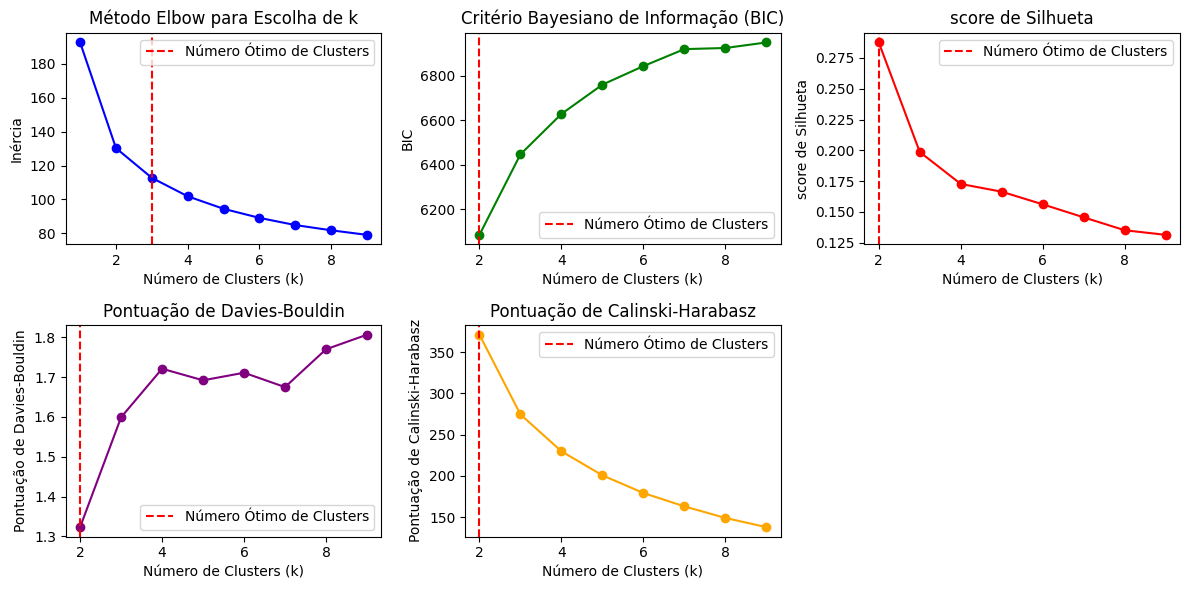

Número ótimo de clusters (Elbow Method - Inércia): 3
Número ótimo de clusters (BIC): 2
Número ótimo de clusters (Escore de Silhueta): 2
Número ótimo de clusters (Davies-Bouldin): 2
Número ótimo de clusters (Calinski-Harabasz): 2


In [109]:
knee_inertia = KneeLocator(range(min_clusters-1, max_clusters), inertia_values, curve='convex', direction='decreasing')
optimal_clusters_inertia = knee_inertia.elbow

optimal_clusters_bic = np.argmin(bic_scores) + min_clusters
optimal_clusters_silhouette = np.argmax(silhouette_scores) + min_clusters
optimal_clusters_davies_bouldin = np.argmin(davies_bouldin_scores) + min_clusters
optimal_clusters_calinski_harabasz = np.argmax(calinski_harabasz_scores) + min_clusters

# Plot da inércia
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.plot(range(min_clusters-1, max_clusters), inertia_values, marker='o', linestyle='-', color='b')
plt.axvline(x=optimal_clusters_inertia, color='red', linestyle='--', label='Número Ótimo de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método Elbow para Escolha de k')
plt.legend()

# Plot do BIC
plt.subplot(2, 3, 2)
plt.plot(range(min_clusters, max_clusters), bic_scores, marker='o', linestyle='-', color='g')
plt.axvline(x=optimal_clusters_bic, color='red', linestyle='--', label='Número Ótimo de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('BIC')
plt.title('Critério Bayesiano de Informação (BIC)')
plt.legend()

# Plot do escore de silhueta
plt.subplot(2, 3, 3)
plt.plot(range(min_clusters, max_clusters), silhouette_scores, marker='o', linestyle='-', color='r')
plt.axvline(x=optimal_clusters_silhouette, color='red', linestyle='--', label='Número Ótimo de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('score de Silhueta')
plt.title('score de Silhueta')
plt.legend()

# Plot da pontuação de Davies-Bouldin
plt.subplot(2, 3, 4)
plt.plot(range(min_clusters, max_clusters), davies_bouldin_scores, marker='o', linestyle='-', color='purple')
plt.axvline(x=optimal_clusters_davies_bouldin, color='red', linestyle='--', label='Número Ótimo de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Pontuação de Davies-Bouldin')
plt.title('Pontuação de Davies-Bouldin')
plt.legend()

# Plot da pontuação de Calinski-Harabasz
plt.subplot(2, 3, 5)
plt.plot(range(min_clusters, max_clusters), calinski_harabasz_scores, marker='o', linestyle='-', color='orange')
plt.axvline(x=optimal_clusters_calinski_harabasz, color='red', linestyle='--', label='Número Ótimo de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Pontuação de Calinski-Harabasz')
plt.title('Pontuação de Calinski-Harabasz')
plt.legend()

# Exibir os gráficos
plt.tight_layout()
plt.show()

print(f"Número ótimo de clusters (Elbow Method - Inércia): {optimal_clusters_inertia}")
print(f"Número ótimo de clusters (BIC): {optimal_clusters_bic}")
print(f"Número ótimo de clusters (Escore de Silhueta): {optimal_clusters_silhouette}")
print(f"Número ótimo de clusters (Davies-Bouldin): {optimal_clusters_davies_bouldin}")
print(f"Número ótimo de clusters (Calinski-Harabasz): {optimal_clusters_calinski_harabasz}")

Melhor K com base nas métricas acima é 2.

## K-Means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


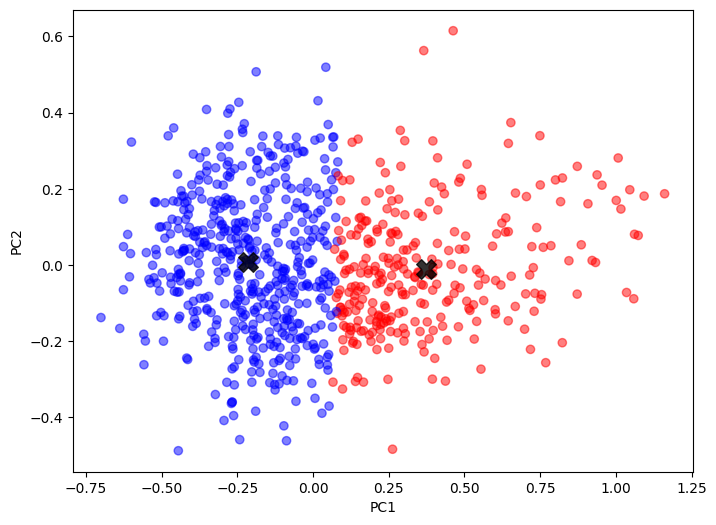

In [110]:
#Treino com o melhor K
optimal_clusters = 2
kmeans_optimal = KMeans(n_clusters=optimal_clusters)
kmeans_optimal.fit(data)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(data.values)

fig, ax = plt.subplots(figsize=(8, 6))
colors = np.array(['red', 'blue'])
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors[kmeans_optimal.labels_], alpha=0.5)
ax.scatter(pca.transform(kmeans_optimal.cluster_centers_)[:, 0], pca.transform(kmeans_optimal.cluster_centers_)[:, 1],
           c='black', s=200, alpha=0.8, marker='X')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

## K-Medoids

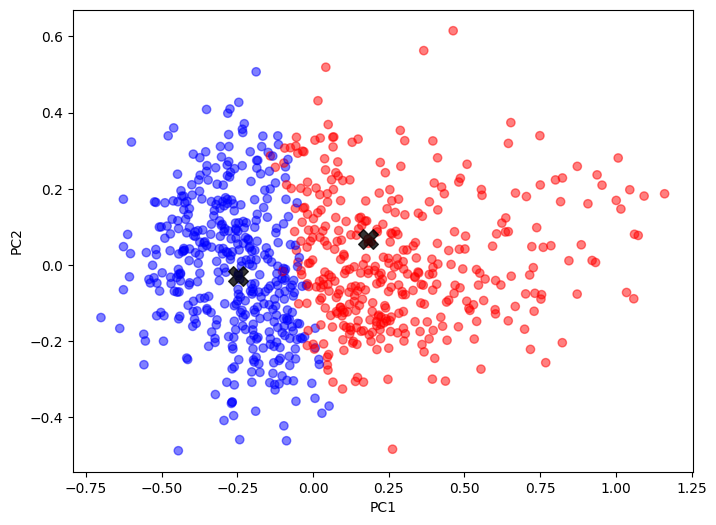

In [111]:
#Treino com o melhor K
kmedoids_optimal = KMedoids(n_clusters=optimal_clusters)
kmedoids_optimal.fit(data)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(data.values)

fig, ax = plt.subplots(figsize=(8, 6))
colors = np.array(['red', 'blue'])
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors[kmedoids_optimal.labels_], alpha=0.5)
ax.scatter(pca.transform(kmedoids_optimal.cluster_centers_)[:, 0], pca.transform(kmedoids_optimal.cluster_centers_)[:, 1],
           c='black', s=200, alpha=0.8, marker='X')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

##Comparação KMeans e KMedoids

In [112]:
distances_kmeans = pairwise_distances(data, kmeans_optimal.cluster_centers_)
bic_value_kmeans = bic_score(kmeans, data)
silhouette_optimal_kmeans = silhouette_score(data, kmeans_optimal.labels_)
davies_bouldin_optimal_kmeans = davies_bouldin_score(data, kmeans_optimal.labels_)
calinski_harabasz_optimal_kmeans = calinski_harabasz_score(data, kmeans_optimal.labels_)

distances_kmedoids = pairwise_distances(data, kmedoids_optimal.cluster_centers_)
bic_value_kmedoids = bic_score(kmedoids_optimal, data)
silhouette_optimal_kmedoids = silhouette_score(data, kmedoids_optimal.labels_)
davies_bouldin_optimal_kmedoids = davies_bouldin_score(data, kmedoids_optimal.labels_)
calinski_harabasz_optimal_kmedoids = calinski_harabasz_score(data, kmedoids_optimal.labels_)

In [113]:
print(f"Número ótimo de clusters: {optimal_clusters}\n\n")
print(f"Distâncias intra-clusters (KMeans):\n{distances_kmeans}")
print(f"Índice BIC (KMeans): {bic_value_kmeans:.2f}")
print(f"Silhouette Score (KMeans): {silhouette_optimal_kmeans:.2f}")
print(f"Davies-Bouldin Index (KMeans): {davies_bouldin_optimal_kmeans:.2f}")
print(f"Calinski-Harabasz Index (KMeans): {calinski_harabasz_optimal_kmeans:.2f}\n")
print(f"Distâncias intra-clusters (KMedoid):\n{distances_kmedoids}")
print(f"Índice BIC (KMedoid): {bic_value_kmedoids:.2f}")
print(f"Silhouette Score (KMedoid): {silhouette_optimal_kmedoids:.2f}")
print(f"Davies-Bouldin Index (KMedoid): {davies_bouldin_optimal_kmedoids:.2f}")
print(f"Calinski-Harabasz Index (KMedoid): {calinski_harabasz_optimal_kmedoids:.2f}")

Número ótimo de clusters: 2


Distâncias intra-clusters (KMeans):
[[0.693909   0.19951616]
 [0.75341966 0.62507088]
 [0.53535684 0.32267232]
 ...
 [0.58644479 0.22774915]
 [0.94906651 1.4613338 ]
 [0.66106124 0.47515781]]
Índice BIC (KMeans): 6948.44
Silhouette Score (KMeans): 0.29
Davies-Bouldin Index (KMeans): 1.32
Calinski-Harabasz Index (KMeans): 371.26

Distâncias intra-clusters (KMedoid):
[[0.49694331 0.19556843]
 [0.73002531 0.65125503]
 [0.45556497 0.33021115]
 ...
 [0.42880201 0.27033151]
 [1.11586012 1.48080371]
 [0.54176952 0.49450849]]
Índice BIC (KMedoid): 5396.08
Silhouette Score (KMedoid): 0.25
Davies-Bouldin Index (KMedoid): 1.42
Calinski-Harabasz Index (KMedoid): 337.91


Ao avaliar as métricas, o KMeans obteve um desempenho um pouco melhor, apesar de ter um BIC pior quando comparado com o KMedoids. Por isso, utilizaremos o KMeans para realizar as próximas comparações.

##Perguntas

Nesta seção é exibida as características estatíscas dos clusters formados pelo KMeans e também dos clusters feito a partir do atributo binário "Private". Apesar desta coluna ter sido retirada para o treinamento, ela aqui retorna para efeito comparativo. Apesar do KMeans ter divido em dois grupos o dataset, são grupos muito diferentes do intuito incial (Faculdade Privada ou Pública). Ao analisar medidas como a média e desvio padrão, a distribuição por variável e posteriormente a plotagem dos cluster em relação a "Private", torna-se claro as diferenças e possibilita uma análise mais profunda. Em outras palavras, a partir dos dados abaixos, podemos responder a média, a distribuição e consequentemente a importância de cada variável no cluster.

In [114]:
data_cluster_0 = data[kmeans.labels_ == 0]
data_cluster_0.describe()

,Apps,Top10perc,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,S.F.Ratio,perc.alumni,Expend,Grad.Rate
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,0.018577,0.152632,0.024759,0.386712,0.418430,0.214073,0.156670,0.349909,0.298650,0.222791,0.088318,0.475575
std,0.021040,0.076955,0.021927,0.085563,0.130392,0.138013,0.123343,0.132186,0.107519,0.107601,0.043457,0.150672
min,0.000396,0.000000,0.000504,0.200930,0.162673,0.057487,0.022901,0.000000,0.000000,0.031250,0.021415,0.129630
25%,0.006733,0.094737,0.007900,0.324251,0.313288,0.149398,0.074046,0.294737,0.257373,0.140625,0.063076,0.388889
50%,0.010456,0.152632,0.016922,0.384039,0.410230,0.180036,0.129771,0.368421,0.284182,0.234375,0.085075,0.453704
75%,0.018958,0.207895,0.032665,0.443569,0.489833,0.224599,0.190840,0.421053,0.345845,0.292969,0.102409,0.537037
max,0.106346,0.368421,0.100527,0.597107,0.766551,1.000000,0.711908,0.568421,0.662198,0.468750,0.276585,1.000000


In [115]:
data_cluster_1 = data[kmeans.labels_ == 1]
data_cluster_1.describe()

,Apps,Top10perc,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,S.F.Ratio,perc.alumni,Expend,Grad.Rate
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.037923,0.402961,0.005057,0.650935,0.446355,0.185453,0.097055,0.798684,0.255502,0.597656,0.182150,0.612461
std,0.026848,0.117372,0.006960,0.129121,0.106837,0.047593,0.053238,0.092542,0.054923,0.126146,0.082082,0.093918
min,0.002728,0.200000,0.000000,0.322211,0.237232,0.090909,0.007634,0.284211,0.107239,0.359375,0.075952,0.351852
25%,0.019802,0.305263,0.001225,0.563481,0.371611,0.143828,0.057443,0.744737,0.224531,0.500000,0.134654,0.553241
50%,0.032356,0.378947,0.002267,0.647469,0.421658,0.180036,0.086336,0.800000,0.257373,0.578125,0.168483,0.625000
75%,0.046373,0.484211,0.006549,0.734039,0.511901,0.224599,0.130344,0.873684,0.281501,0.656250,0.206840,0.675926
max,0.146544,0.705263,0.038425,1.000000,0.692623,0.313725,0.297710,0.957895,0.442359,0.937500,0.749147,0.833333


In [122]:
data['Private'] = binary_att
data_public_colleges = data[data['Private'] == 0]
data_private_colleges = data[data['Private'] == 1]

In [117]:
data_public_colleges.describe()

,Apps,Top10perc,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.0
mean,0.117654,0.229841,0.090551,0.231065,0.310252,0.204268,0.217860,0.724578,0.392471,0.224351,0.080538,0.426319,0.0
std,0.111859,0.170320,0.106299,0.110808,0.135268,0.060486,0.103438,0.129658,0.091637,0.117483,0.050814,0.135032,0.0
min,0.003166,0.000000,0.000366,0.012397,0.000000,0.000000,0.022901,0.263158,0.112601,0.000000,0.007899,0.000000,0.0
25%,0.043941,0.115789,0.027433,0.156302,0.211460,0.180036,0.145038,0.663158,0.337802,0.140625,0.047675,0.333333,0.0
50%,0.088018,0.189474,0.062926,0.220506,0.303909,0.202317,0.213588,0.742105,0.395442,0.210938,0.066554,0.416667,0.0
75%,0.159155,0.278947,0.114232,0.284298,0.406999,0.229947,0.275000,0.821053,0.451072,0.296875,0.101500,0.509259,0.0
max,1.000000,0.989474,1.000000,0.691736,0.750315,0.458556,0.616489,1.000000,0.705094,0.750000,0.251494,0.833333,0.0


In [118]:
data_private_colleges.describe()

,Apps,Top10perc,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private
count,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.0
mean,0.039509,0.298221,0.019829,0.488724,0.442330,0.201206,0.147243,0.664145,0.280040,0.404535,0.137620,0.546280,1.0
std,0.050889,0.187909,0.033083,0.191502,0.171768,0.077956,0.096623,0.182641,0.094332,0.193762,0.107123,0.155088,0.0
min,0.000000,0.000000,0.000000,0.000000,0.093001,0.068627,0.000000,0.000000,0.000000,0.031250,0.000000,0.046296,1.0
25%,0.011205,0.168421,0.002839,0.349174,0.308323,0.157754,0.083969,0.547368,0.230563,0.250000,0.080891,0.444444,1.0
50%,0.021911,0.252632,0.009434,0.457645,0.412989,0.180036,0.129771,0.684211,0.273458,0.390625,0.108734,0.546296,1.0
75%,0.043842,0.368421,0.024731,0.600723,0.570618,0.224599,0.190840,0.810526,0.321716,0.531250,0.159085,0.657407,1.0
max,0.418866,1.000000,0.468056,1.000000,1.000000,1.000000,1.000000,0.968421,1.000000,1.000000,1.000000,1.000000,1.0


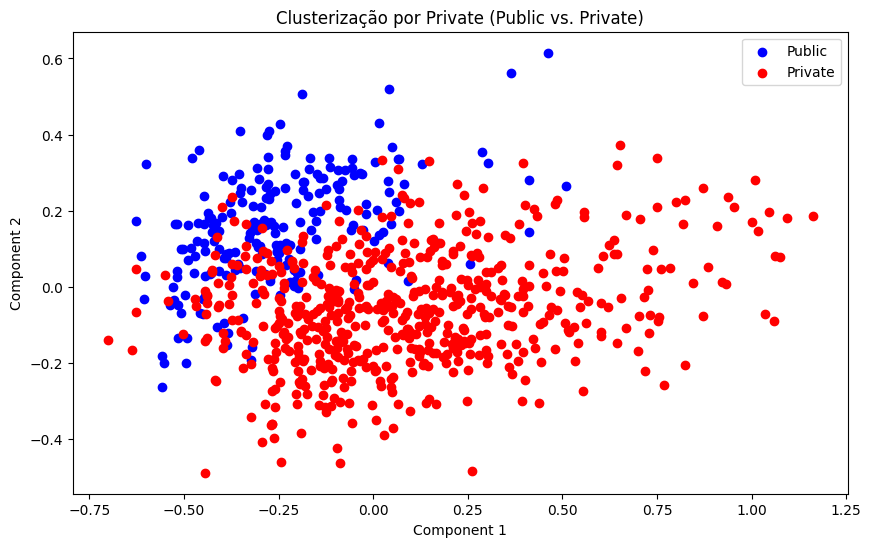

In [119]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data.iloc[:, :-1])  # Exclua a coluna 'Private' para a redução de dimensionalidade
data_pca_with_private = pd.DataFrame(data_pca, columns=['Component 1', 'Component 2'])
data_pca_with_private['Private'] = data['Private']
data_public_colleges_pca = data_pca_with_private[data_pca_with_private['Private'] == 0]
data_private_colleges_pca = data_pca_with_private[data_pca_with_private['Private'] == 1]

plt.figure(figsize=(10, 6))
plt.scatter(data_public_colleges_pca['Component 1'], data_public_colleges_pca['Component 2'], c='blue', label='Public')
plt.scatter(data_private_colleges_pca['Component 1'], data_private_colleges_pca['Component 2'], c='red', label='Private')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.title('Clusterização por Private (Public vs. Private)')
plt.show()


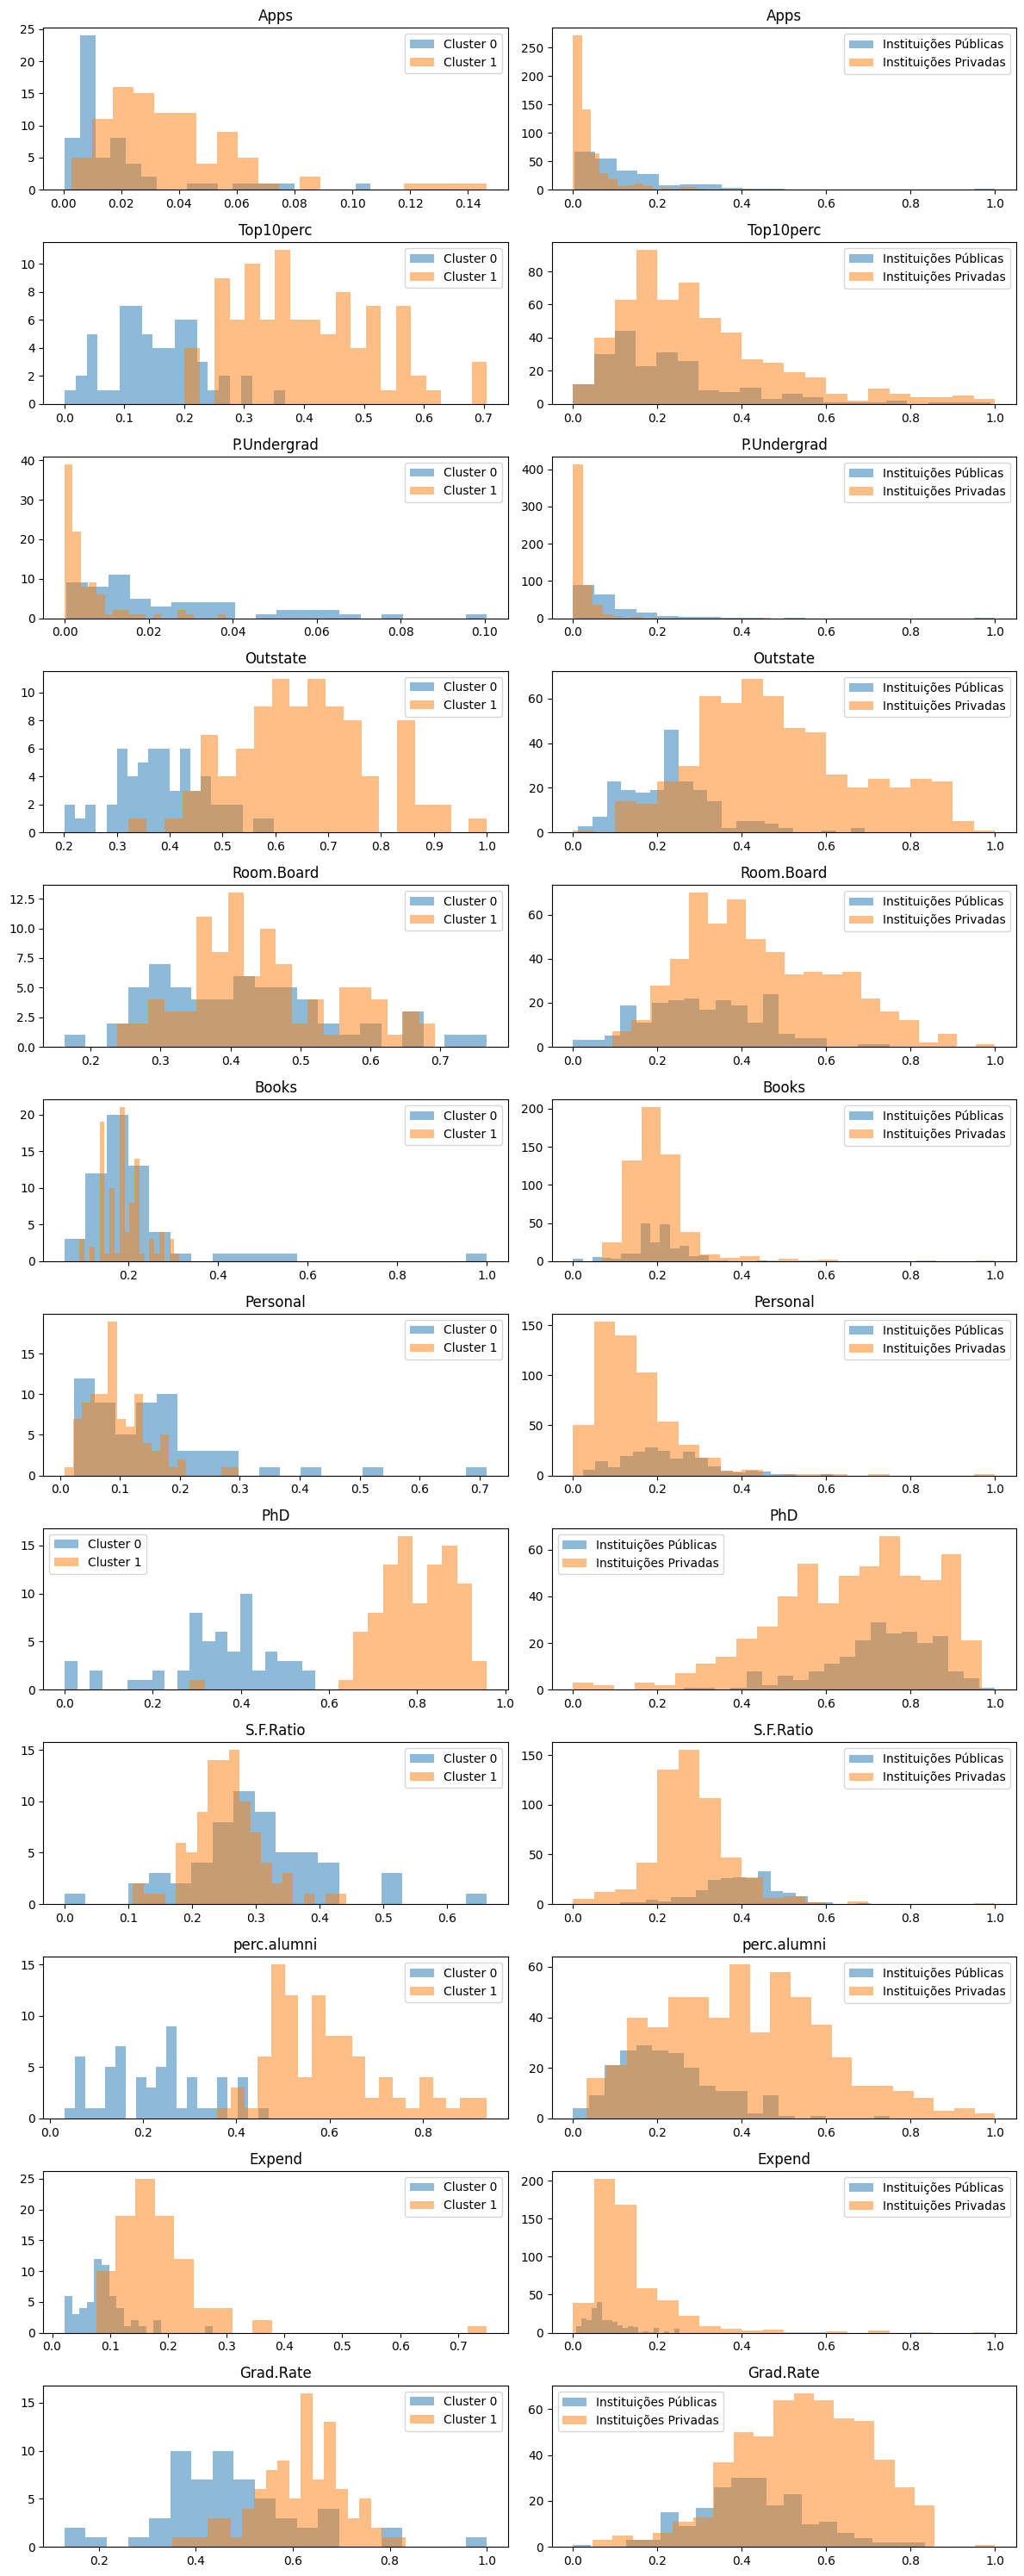

In [126]:
columns_to_compare = data_cluster_0.columns
num_rows = len(columns_to_compare)
num_cols = 2

plt.figure(figsize=(12, 30))

for i, col in enumerate(columns_to_compare):
  plt.subplot(num_rows, num_cols, i * num_cols + 1)
  plt.hist(data_cluster_0[col], alpha=0.5, label='Cluster 0', bins=20)
  plt.hist(data_cluster_1[col], alpha=0.5, label='Cluster 1', bins=20)
  plt.title(col)
  plt.legend()

  plt.subplot(num_rows, num_cols, i * num_cols + 2)
  plt.hist(data_public_colleges[col], alpha=0.5, label='Instituições Públicas', bins=20)
  plt.hist(data_private_colleges[col], alpha=0.5, label='Instituições Privadas', bins=20)
  plt.title(col)
  plt.legend()

plt.tight_layout()
plt.show()

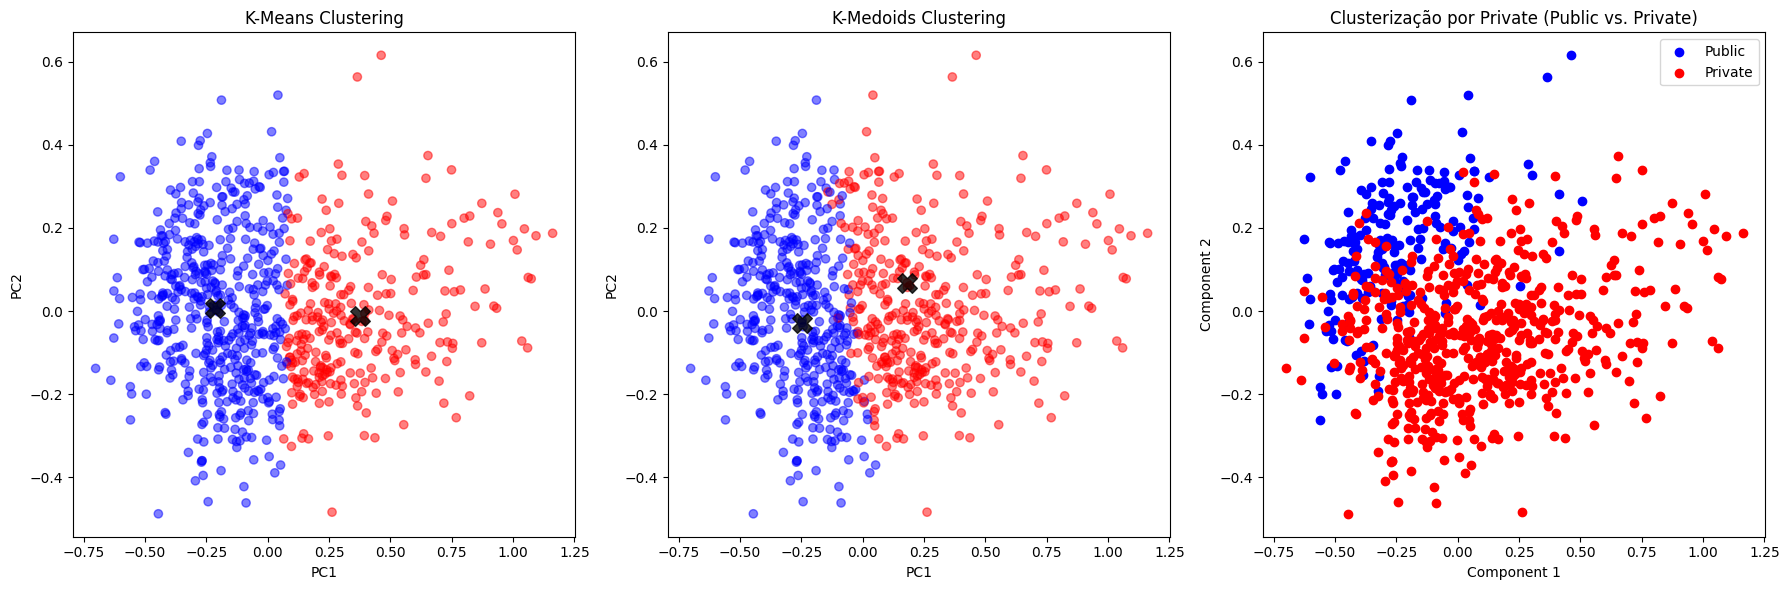

In [130]:
# Primeiro gráfico: K-Means
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data.iloc[:, :-1].values)

# Segundo gráfico: K-Medoids
pca_kmedoids = PCA(n_components=2)
X_pca_kmedoids = pca_kmedoids.fit_transform(data.iloc[:, :-1].values)

# Terceiro gráfico: Clusterização por Private
pca_private = PCA(n_components=2)
data_pca = pca_private.fit_transform(data.iloc[:, :-1])
data_pca_with_private = pd.DataFrame(data_pca, columns=['Component 1', 'Component 2'])
data_pca_with_private['Private'] = data['Private']
data_public_colleges_pca = data_pca_with_private[data_pca_with_private['Private'] == 0]
data_private_colleges_pca = data_pca_with_private[data_pca_with_private['Private'] == 1]


plt.figure(figsize=(18, 6))

# Subplot 1: K-Means
plt.subplot(1, 3, 1)
colors = np.array(['red', 'blue'])
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors[kmeans_optimal.labels_], alpha=0.5)
plt.scatter(pca.transform(kmeans_optimal.cluster_centers_)[:, 0], pca.transform(kmeans_optimal.cluster_centers_)[:, 1],
           c='black', s=200, alpha=0.8, marker='X')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering')

# Subplot 2: K-Medoids
plt.subplot(1, 3, 2)
colors = np.array(['red', 'blue'])
plt.scatter(X_pca_kmedoids[:, 0], X_pca_kmedoids[:, 1], c=colors[kmedoids_optimal.labels_], alpha=0.5)
plt.scatter(pca_kmedoids.transform(kmedoids_optimal.cluster_centers_)[:, 0], pca_kmedoids.transform(kmedoids_optimal.cluster_centers_)[:, 1],
           c='black', s=200, alpha=0.8, marker='X')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Medoids Clustering')

# Subplot 3: Clusterização por Private
plt.subplot(1, 3, 3)
plt.scatter(data_public_colleges_pca['Component 1'], data_public_colleges_pca['Component 2'], c='blue', label='Public')
plt.scatter(data_private_colleges_pca['Component 1'], data_private_colleges_pca['Component 2'], c='red', label='Private')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.title('Clusterização por Private (Public vs. Private)')

plt.tight_layout()
plt.show()


##Salvar em PDF

In [131]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
pandoc set to manually installed.
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1
  libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:


In [132]:
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Colab Notebooks/SI/Kmeans_Kmedoids.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/SI/Kmeans_Kmedoids.ipynb to PDF
[NbConvertApp] Support files will be in Kmeans_Kmedoids_files/
[NbConvertApp] Making directory ./Kmeans_Kmedoids_files
[NbConvertApp] Making directory ./Kmeans_Kmedoids_files
[NbConvertApp] Making directory ./Kmeans_Kmedoids_files
[NbConvertApp] Making directory ./Kmeans_Kmedoids_files
[NbConvertApp] Making directory ./Kmeans_Kmedoids_files
[NbConvertApp] Making directory ./Kmeans_Kmedoids_files
[NbConvertApp] Making directory ./Kmeans_Kmedoids_files
[NbConvertApp] Making directory ./Kmeans_Kmedoids_files
[NbConvertApp] Writing 111515 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1073811 byt